In [1]:
import torch
from pathlib import Path
import pytorch_lightning as pl
# should use pytorch-lightning 1.7.7 since the model is targeted for this version
assert pl.__version__ == "1.7.7"

import os
# os.environ["DARTS_CONFIGURE_MATPLOTLIB"] = "0"

/home/beomyeol/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(path, map_location=None):
    path = Path(path)

    scaler_path = path.with_name("scaler.pt")
    scaler = torch.load(scaler_path)

    with open(path, "rb") as fin:
        model = torch.load(fin, map_location=map_location)

    ckpt_path = path.with_name(path.name + ".ckpt")
    if ckpt_path.exists():
        model.model = model.model.__class__.load_from_checkpoint(ckpt_path)
        model.trainer = None

    # print(model.trainer_params)
    model.trainer_params = {"enable_progress_bar": False, "logger": False}
    # model.trainer_params = {}

    return model, scaler

map_location = "cpu"
path = "../../results/pred/scaled_by_day8_max40_sample8_day8-12/darts/clen=60_plen=40/nhits/bs=32_lr=0.0001/b=2_s=3_l=4_lw=256_do=0.1/model.pt"
prob_path = "../../results/pred/scaled_by_day8_max40_sample8_day8-12/darts/clen=60_plen=40/nhits/bs=32_lr=0.0001/b=2_s=3_l=4_lw=256_do=0.1_gaussian/model.pt"
model, scaler = load_model(path, map_location=map_location)
prob_model, prob_scaler = load_model(prob_path, map_location=map_location)

In [3]:
import matplotlib.pyplot as plt
context_len = model.input_chunk_length
pred_len = model.output_chunk_length
print(context_len)
print(pred_len)

60
40


In [7]:
import sys
sys.path.append("../..")
import pandas as pd
from pred.utils import build_dataset_from_df
from darts import TimeSeries

df = pd.read_pickle("../../data/azure/2019/scaled_by_day8_max40_sample8_day8-12.pkl")
val = build_dataset_from_df(df[df.day == 8])
val = TimeSeries.from_group_dataframe(
        val, group_cols="group", time_col="time_idx", value_cols="value")

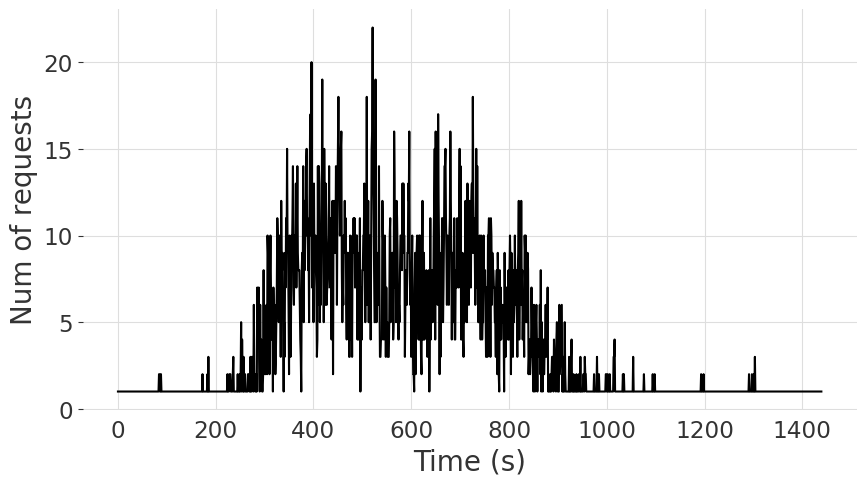

In [8]:
factor = 1.3
figsize = ((6.4 * 1.2) * factor, 4 * factor)
plt.rcParams.update({'font.size': 20, 'axes.labelweight': 400, 'legend.frameon': True, "xtick.labelsize": "small", "ytick.labelsize": "small"})
target = val[2]

fig, ax = plt.subplots(figsize=figsize)
target.plot(ax=ax, default_formatting=False, linewidth=1.5, color="black")
ax.set_ylabel("Num of requests")
ax.set_xlabel("Time (s)")
ax.get_legend().remove()
fig.savefig("images/sample_workload.png", bbox_inches="tight")

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/beomyeol/anaconda3/envs/k8s-ray/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/beomyeol/anaconda3/envs/k8s-ray/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


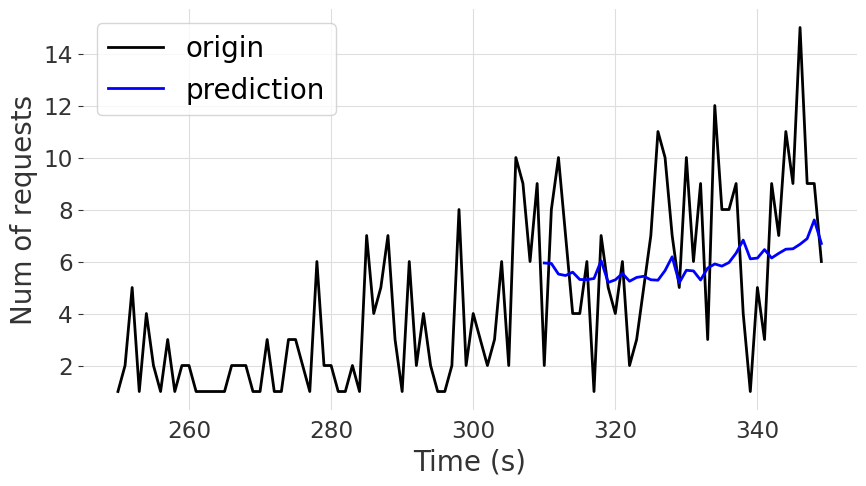

In [9]:
base = 250
series = target[base:base+context_len]
scaled_series = scaler.transform(series)
pred = model.predict(n=pred_len, series=scaled_series)
pred_out = scaler.inverse_transform(pred)

# target[base:base+context_len+pred_len].plot(label="origin")
# pred_out.plot(label="prediction")
fig, ax = plt.subplots(figsize=figsize)
target[base:base+context_len+pred_len].plot(label="origin", ax=ax, default_formatting=False, linewidth=2, color="black")
pred_out.plot(label="prediction", ax=ax, default_formatting=True, linewidth=2, color="blue")
ax.set_ylabel("Num of requests")
ax.set_xlabel("Time (s)")
fig.savefig("images/pred_sample2.png", bbox_inches="tight")

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/beomyeol/anaconda3/envs/k8s-ray/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/beomyeol/anaconda3/envs/k8s-ray/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


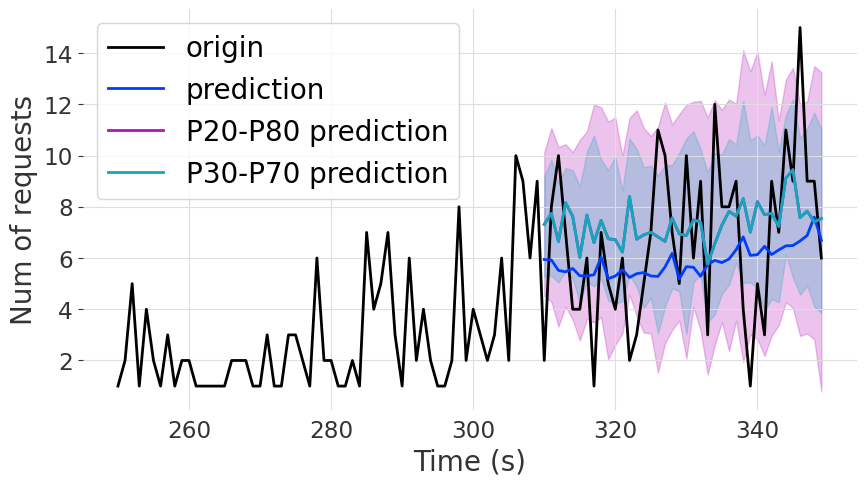

In [10]:
base = 250
series = target[base:base+context_len]
scaled_series = scaler.transform(series)
prob_pred = prob_model.predict(n=pred_len, series=scaled_series, num_samples=100)
prob_pred_out = scaler.inverse_transform(prob_pred)

# target[base:base+context_len+pred_len].plot(label="origin")
# pred_out.plot(label="pred")
fig, ax = plt.subplots(figsize=figsize)
target[base:base+context_len+pred_len].plot(label="origin", ax=ax, linewidth=2)
pred_out.plot(label="prediction", ax=ax, linewidth=2)
# prob_pred_out.plot(low_quantile=0.2, high_quantile=0.8, label=r"$20^{th}-80^{th}$ percentile", ax=ax, linewidth=1.5)
prob_pred_out.plot(low_quantile=0.2, high_quantile=0.8, label="P20-P80 prediction", ax=ax, linewidth=2)
prob_pred_out.plot(low_quantile=0.3, high_quantile=0.7, label="P30-P70 prediction", ax=ax, linewidth=2)
ax.set_ylabel("Num of requests")
ax.set_xlabel("Time (s)")
fig.savefig("images/pred_sample2_gaussian.png", bbox_inches="tight")